<a href="https://colab.research.google.com/github/qubvel/transformers-notebooks/blob/main/notebooks/PromptDepthAnything_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook introduces inference with [Prompt Depth Anything](https://huggingface.co/docs/transformers/main/en/model_doc/prompt_depth_anything).

Prompt Depth Anything is a high-resolution and accurate metric depth estimation method, with the following highlights:
 - Prompting to unleash the power of depth foundation models, inspired by success of prompting in VLM and LLM foundation models.
 - The widely available iPhone LiDAR is taken as the prompt, guiding the model to produce up to 4K resolution accurate metric depth.


Abstract:  
*Prompts play a critical role in unleashing the power of language and vision foundation models for specific tasks. For the first time, we introduce prompting into depth foundation models, creating a new paradigm for metric depth estimation termed Prompt Depth Anything. Specifically, we use a low-cost LiDAR as the prompt to guide the Depth Anything model for accurate metric depth output, achieving up to 4K resolution. Our approach centers on a concise prompt fusion design that integrates the LiDAR at multiple scales within the depth decoder. To address training challenges posed by limited datasets containing both LiDAR depth and precise GT depth, we propose a scalable data pipeline that includes synthetic data LiDAR simulation and real data pseudo GT depth generation. Our approach sets new state-of-the-arts on the ARKitScenes and ScanNet++ datasets and benefits downstream applications, including 3D reconstruction and generalized robotic grasping.*

![](https://promptda.github.io/assets/teaser.jpg)

 - Paper: https://arxiv.org/abs/2412.14015
 - Project Page: https://promptda.github.io/

In this notebook we will cover the following steps:  

 - Loading image and sparse prompt depth
 - Loading pretrained model and image_processor from [HuggingFace Hub](https://huggingface.co/models?other=prompt_depth_anything)
 - Inference WITH provided prompt depth
 - Inference WITHOUT prompt depth
 - Visualization of predicted depth maps

But first, let make sure we have the lates `transformers` installed:

In [1]:
!pip install -U git+https://github.com/haotongl/transformers@modeling_prompt_depth_anything

  Cloning https://github.com/haotongl/transformers (to revision modeling_prompt_depth_anything) to /tmp/pip-req-build-depjefp8
  Running command git clone --filter=blob:none --quiet https://github.com/haotongl/transformers /tmp/pip-req-build-depjefp8
  Running command git checkout -b modeling_prompt_depth_anything --track origin/modeling_prompt_depth_anything
  Switched to a new branch 'modeling_prompt_depth_anything'
  Branch 'modeling_prompt_depth_anything' set up to track remote branch 'modeling_prompt_depth_anything' from 'origin'.
  Resolved https://github.com/haotongl/transformers to commit 2aa3363b7eef98e9c07851f54aa8a2fb76ebbcb2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10314628 sha256=62a210a7da2ba03881532415fe376b507377d277897ee632a7e50202f353ec3f
  Stored in directory: /tmp/pip-ephem-wheel-cache

In [2]:
import torch
import requests
import numpy as np

from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

### Load data

Image size: [1440, 1920]


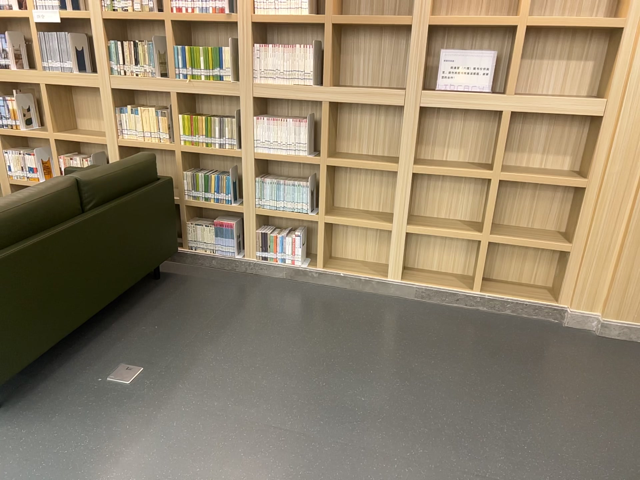

In [4]:
# image for depth estimation
url = "https://github.com/DepthAnything/PromptDA/blob/main/assets/example_images/image.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

print("Image size:", [image.height, image.width])
image.resize((640, 480)) # resize for visualization

### [Optional] Load prompt depth

Prompt depth refers to sparse depth information derived from multi-view geometry or low-resolution depth readings from a depth sensor. It is typically represented as a 2D array with dimensions (height, width), where the height and width can be smaller than those of the corresponding images.

The use of prompt depth is optional. If no prompt depth is provided (None), the model's output will be a monocular relative depth map. However, if a prompt depth is supplied, the model will produce a metric depth map.

Units and Scaling:

In this example, we load a prompt depth map with depth values in millimeters. If your prompt depth data is in a different unit, you can convert it to millimeters or adjust the prompt_scale_to_meter parameter in the image processor (refer to the image processor documentation for more details).

Prompt depth shape: (192, 256)
Prompt depth range: 1566..3512


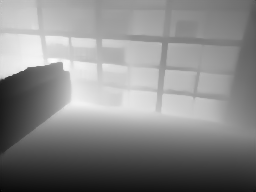

In [6]:
# prompt depth
prompt_depth_url = "https://github.com/DepthAnything/PromptDA/blob/main/assets/example_images/arkit_depth.png?raw=true"
prompt_depth = Image.open(requests.get(prompt_depth_url, stream=True).raw)

prompt_depth_np = np.array(prompt_depth)
min = prompt_depth_np.min()
max = prompt_depth_np.max()

print("Prompt depth shape:", prompt_depth_np.shape)
print(f"Prompt depth range: {min}..{max}")

# normalize for visualization
noramlized_prompt_depth = (prompt_depth_np - min)  / (max - min)
noramlized_prompt_depth = Image.fromarray((noramlized_prompt_depth * 255).astype("uint8"))
noramlized_prompt_depth

### Load model and image processor from the Hugging Face Hub

Image processor is an object responsible for image normalization/resizing and results posprocessing, such as resizing depth map back to the image scale.

In [7]:
image_processor = AutoImageProcessor.from_pretrained("depth-anything/prompt-depth-anything-vits-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/prompt-depth-anything-vits-hf")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/487 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/100M [00:00<?, ?B/s]

### Inference with Prompt Depth provided

In [20]:
# Prepare image and prompt depth for the model
inputs = image_processor(
    images=image,
    prompt_depth=prompt_depth,
    return_tensors="pt",
    # You can adjust the following parameter to convert you depth units to meters
    # prompt_scale_to_meter=0.001,
)
print(f"Preprocessed inputs: {inputs.keys()}")

with torch.no_grad():
    outputs = model(**inputs)

# interpolate to original size
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)
post_processed_output

Preprocessed inputs: dict_keys(['pixel_values', 'prompt_depth'])


[{'predicted_depth': tensor([[3.0111, 3.0064, 2.9996,  ..., 2.2451, 2.2464, 2.2473],
          [3.0083, 3.0061, 3.0030,  ..., 2.2451, 2.2462, 2.2470],
          [3.0040, 3.0056, 3.0083,  ..., 2.2450, 2.2458, 2.2464],
          ...,
          [1.6697, 1.6655, 1.6590,  ..., 1.7653, 1.7711, 1.7749],
          [1.6919, 1.6807, 1.6635,  ..., 1.7681, 1.7796, 1.7870],
          [1.7063, 1.6906, 1.6665,  ..., 1.7700, 1.7852, 1.7951]])}]

In [14]:
predicted_depth = post_processed_output[0]["predicted_depth"]

min = predicted_depth.min().item()
max = predicted_depth.max().item()

print("Predicted depth shape:", predicted_depth.shape)
print(f"Predicted depth range: {min:.2f}..{max:.2f} (meters)")

Predicted depth shape: torch.Size([1440, 1920])
Predicted depth range: 1.65..3.66 (meters)


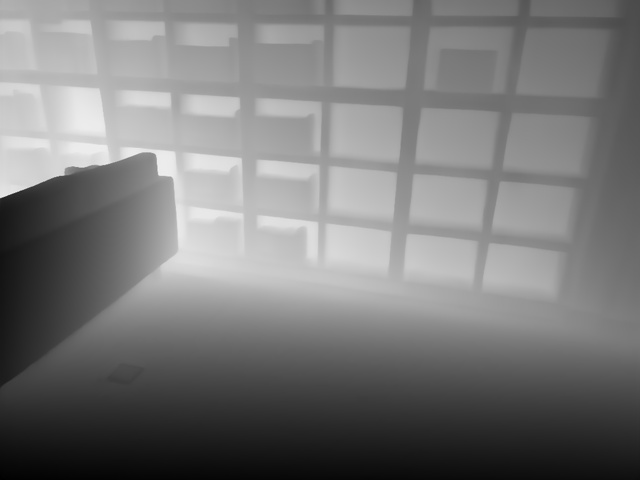

In [15]:
# Visualize the prediction
normalized_depth = (predicted_depth - min)  / (max - min)
normalized_depth = normalized_depth.cpu().numpy()
normalized_depth = Image.fromarray((normalized_depth * 255).astype("uint8"))

normalized_depth.resize([640, 480])

### Inference without Prompt Depth provided

In [21]:
# prepare image for the model, promt_depth is not provided
inputs = image_processor(images=image, return_tensors="pt")
print(f"Preprocessed inputs: {inputs.keys()}")

with torch.no_grad():
    outputs = model(**inputs)

# interpolate to original size
post_processed_output_no_prompt = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)
post_processed_output_no_prompt

Preprocessed inputs: dict_keys(['pixel_values'])


[{'predicted_depth': tensor([[0.5024, 0.5053, 0.5098,  ..., 0.3348, 0.3366, 0.3377],
          [0.5011, 0.5047, 0.5103,  ..., 0.3358, 0.3367, 0.3373],
          [0.4992, 0.5038, 0.5111,  ..., 0.3373, 0.3370, 0.3368],
          ...,
          [0.3674, 0.3690, 0.3715,  ..., 0.3711, 0.3650, 0.3611],
          [0.3718, 0.3711, 0.3701,  ..., 0.3666, 0.3600, 0.3558],
          [0.3748, 0.3725, 0.3692,  ..., 0.3637, 0.3568, 0.3524]])}]

In [22]:
predicted_depth_relative = post_processed_output_no_prompt[0]["predicted_depth"]

min = predicted_depth_relative.min().item()
max = predicted_depth_relative.max().item()

print("Predicted depth shape:", predicted_depth_relative.shape)
print(f"Predicted depth range: {min:.2f}..{max:.2f} (relative units)")

Predicted depth shape: torch.Size([1440, 1920])
Predicted depth range: 0.16..1.14 (relative units)


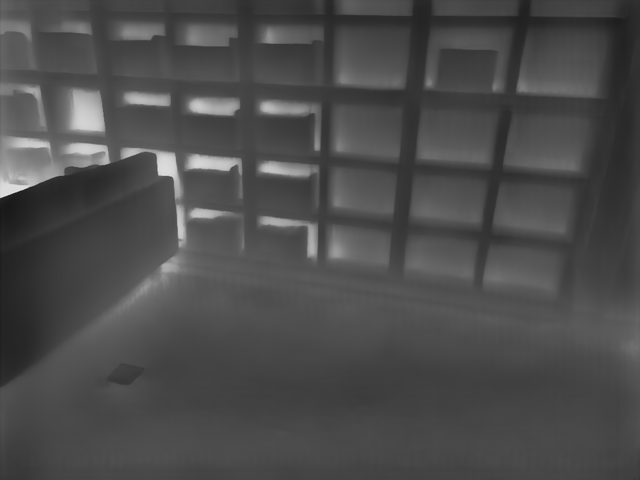

In [23]:
# Visualize the prediction
normalized_depth_relative = (predicted_depth_relative - min)  / (max - min)
normalized_depth_relative = normalized_depth_relative.cpu().numpy()
normalized_depth_relative = Image.fromarray((normalized_depth_relative * 255).astype("uint8"))

normalized_depth_relative.resize([640, 480])

### Visualize all together

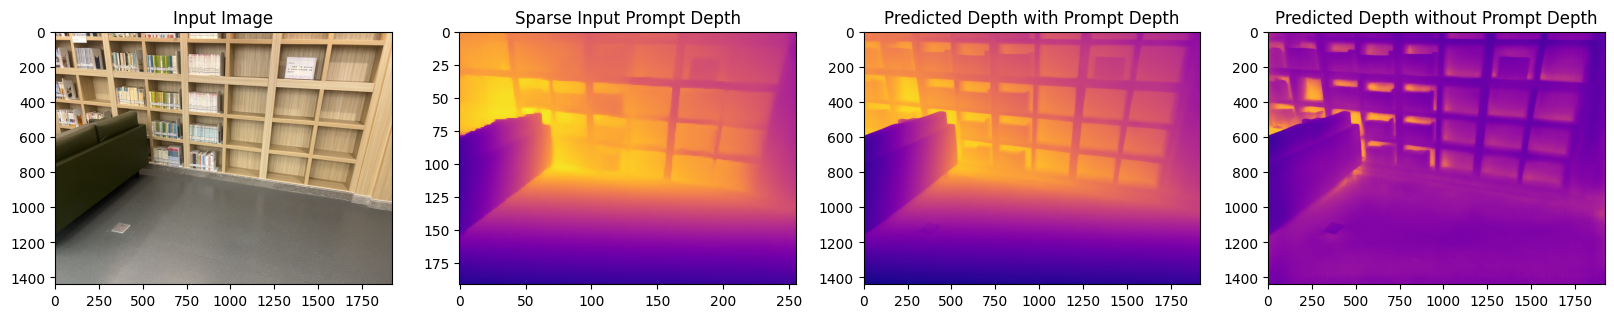

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.title("Input Image")
plt.imshow(image)

plt.subplot(1, 4, 2)
plt.title("Sparse Input Prompt Depth")
plt.imshow(noramlized_prompt_depth, cmap='plasma')

plt.subplot(1, 4, 3)
plt.title("Predicted Depth with Prompt Depth")
plt.imshow(normalized_depth, cmap='plasma')

plt.subplot(1, 4, 4)
plt.title("Predicted Depth without Prompt Depth")
plt.imshow(normalized_depth_relative, cmap='plasma')

plt.show()